In [57]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix as cm



#set tensorflow global options
tf.config.run_functions_eagerly(True)
AUTOTUNE = tf.data.AUTOTUNE

To work with the CervAI folder within collab, it is necessary to add the CervAI folder as your shortcut to your own personal drive.

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#set path to cervAI folder shortcut within local gdrive
project_folder = os.path.join('content/drive/MyDrive','cerv_AI')
project_folder = '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi'
#set working directory to project/data folder
#os.chdir(project_folder)
data_folder = os.path.join(project_folder,'Data')
raw_data_folder = os.path.join(project_folder,'Data/raw')
os.chdir(raw_data_folder)

In [4]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw'

# Unzipping datasets if needed:

In [5]:
for file in os.listdir(os.getcwd()):
  if file[-4:] == '.zip': #only look at .zip files
    if file.split('.')[0] not in os.listdir(): #check if unzipped folder already exists
      file_path_to_unzip = os.path.join(os.getcwd(), file) #get path to zip file
      unzipped_file_path = os.path.join(os.getcwd(),file.split('.')[0]) #create new filepath for unzipped
      !unzip $file_path_to_unzip -d $unzipped_file_path #unzip folder
      print(f'{file} unzipped successfully')
    else: 
        print(f'{file} already unzipped')


cervix_93.zip already unzipped
cric_cropped.zip already unzipped
mendeley_hussain_liquid_based_cytology.zip already unzipped
CRIC_FullSlide_dataset.zip already unzipped


# Configure ML Flow details

In [6]:
!pip install git+https://github.com/mlflow/mlflow@master
import mlflow
from getpass import getpass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mlflow/mlflow (to revision master) to /tmp/pip-req-build-dgniv20i
  Running command git clone -q https://github.com/mlflow/mlflow /tmp/pip-req-build-dgniv20i
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [7]:
MLFLOW_TRACKING_URI='https://dagshub.com/Omdena/Drcadx.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'l.s.hamnett'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.tensorflow.autolog()

Enter your DAGsHub access token or password: ··········


# Define common file handlers for all datasets

In [8]:
#define functions to turn list of file names and labels into a tensorflow dataset
def parse_image(filename):
  
    image = tf.io.read_file(filename) #read filename
    image = tf.io.decode_png(image, channels=0) #convert from png greyscale
    return image 

#wrap parse image function as tensorflow function for opimisation
def tf_parse_image(input):
  y = tf.numpy_function(parse_image, [input],tf.float32) 
  return y 

#create tf dataset
def create_tf_dataset(filepaths,labels):
  filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths)
  images_ds = filenames_ds.map(lambda x: parse_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds_out = tf.data.Dataset.zip((images_ds, labels_ds))
  #ds_out = tf.data.Dataset.from_tensor_slices((images_ds, labels_ds))
  return ds_out

#we can speed up image loading by optimisiming the process
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#given list of labels, return class values
def count_classes(label_list):
  print('total images = ',len(label_list))
  count_zeroes = np.count_nonzero(label_list==0)
  print('number of images with 0 label: ', count_zeroes)   
  count_ones = np.count_nonzero(label_list==1)
  print('number of images with 1 label: ', count_ones)

# Binary classification CRIC_cropped

In [9]:
#set data directory paths
cric_cropped_2_class_dir = os.path.join(raw_data_folder,'cric_cropped/cric_cropped',"Base balanceada dividida","2 classes")
os.chdir(cric_cropped_2_class_dir)
train_dir = os.path.join(cric_cropped_2_class_dir,'Treino')
valid_dir = os.path.join(cric_cropped_2_class_dir,'Validacao')
test_dir = os.path.join(cric_cropped_2_class_dir,'Teste')

In [10]:
#get paths to images and associated labels

def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,filename) # temp filepath
          image_paths.append(temp_path) # add to image paths list
          # if looking at other datasets, below line needs to be modified to get image label from filepath
          temp_label = filename.split('_')[1] #
          labels.append(temp_label) # add label to label list

      #convert list into array
    labels_array = np.array(labels)
    labels_array = labels_array.astype(int)
    return image_paths, labels_array


train_image_paths, train_labels = get_files_labels(train_dir)
valid_image_paths, valid_labels = get_files_labels(valid_dir)

print('training images:')
count_classes(train_labels)

print('valid images:')
count_classes(valid_labels)


training images:
total images =  5514
number of images with 0 label:  2758
number of images with 1 label:  2756
valid images:
total images =  1381
number of images with 0 label:  692
number of images with 1 label:  689


In [11]:
train_ds = create_tf_dataset(train_image_paths, train_labels)
valid_ds = create_tf_dataset(valid_image_paths, valid_labels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


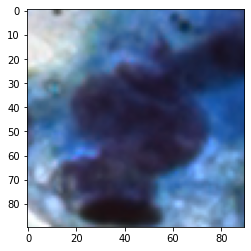

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


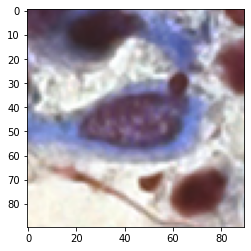

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


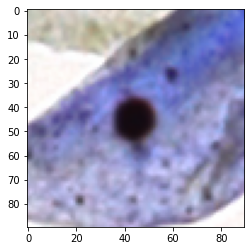

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


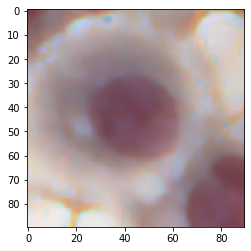

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


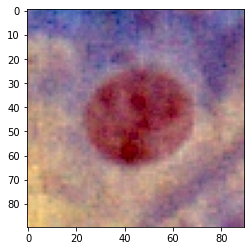

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


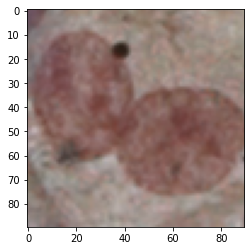

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


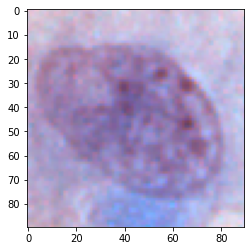

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


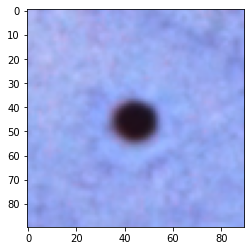

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


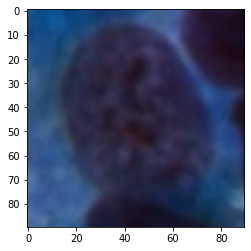

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


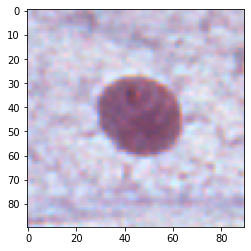

In [12]:
#view some images from dataset to make sure created correctly:
# iterator = train_ds.make_one_shot_iterator()
for images,labels in train_ds.take(10):
  print(tf.shape(images))
  print('label ',labels)
  # print(images)
  # img = mpimg.imread(images)
  #new_image = images[:,:].map(contrast)
  plt.figsize = (10,10)
  plt.imshow(images[:,:,:], vmin=0, vmax=255)
  plt.show()

In [13]:
BATCH_SIZE = 32
train_ds_opt = configure_for_performance(train_ds,BATCH_SIZE)
valid_ds_opt = configure_for_performance(valid_ds,BATCH_SIZE)

In [14]:
for image_batch, labels_batch in train_ds_opt:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 90, 90, 3)
(32,)


In [15]:
#define model
img_height = 90
img_width = 90

model = tf.keras.models.Sequential([
  layers.Rescaling(scale=1./255, input_shape=(img_height,img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

In [16]:
#reset backend
tf.keras.backend.clear_session()

#compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
#define early stopping callback
#if val accuracy decreases 3 times, we are probably overfitting on training data
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True) 

In [18]:
# experiment_id = mlflow.create_experiment(
#     "Binary class: CRIC - cropped",
#     tags={"classif_type": "binary", "dataset": "cric_cropped","image_aug":"none"},
# )

# mlflow.set_experiment(experiment_id)


In [19]:
EPOCHS=10

# with mlflow.start_run():
  # mlflow.log_param("a", 1)
  # # mlflow.log_metric("b", 2)
history = model.fit(
  train_ds_opt,
  validation_data=valid_ds_opt,
  epochs=EPOCHS,
  verbose=2,
  callbacks=callback1)
  # mlflow.log_metric("final loss", loss = )
  # mlflow.log_metric("accuracy", )
  # mlflow.log_metric("mae", mae)


2022/08/14 16:19:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '75eff7fbed1644bca7da45c27e6abb71', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
173/173 - 150s - loss: 0.3664 - accuracy: 0.8308 - val_loss: 0.2526 - val_accuracy: 0.8914 - 150s/epoch - 866ms/step
Epoch 2/10
173/173 - 4s - loss: 0.2542 - accuracy: 0.8928 - val_loss: 0.2126 - val_accuracy: 0.9037 - 4s/epoch - 21ms/step
Epoch 3/10
173/173 - 4s - loss: 0.2239 - accuracy: 0.9086 - val_loss: 0.1986 - val_accuracy: 0.9095 - 4s/epoch - 22ms/step
Epoch 4/10
173/173 - 4s - loss: 0.2117 - accuracy: 0.9120 - val_loss: 0.2075 - val_accuracy: 0.9138 - 4s/epoch - 21ms/step
Epoch 5/10
173/173 - 4s - loss: 0.1822 - accuracy: 0.9262 - val_loss: 0.2476 - val_accuracy: 0.9008 - 4s/epoch - 22ms/step
Epoch 6/10
173/173 - 4s - loss: 0.1746 - accuracy: 0.9316 - val_loss: 0.2229 - val_accuracy: 0.9109 - 4s/epoch - 21ms/step
Epoch 7/10
173/173 - 4s - loss: 0.1438 - accuracy: 0.9436 - val_loss: 0.1739 - val_accuracy: 0.9290 - 4s/epoch - 21ms/step
Epoch 8/10
173/173 - 4s - loss: 0.1467 - accuracy: 0.9391 - val_loss: 0.1904 - val_accuracy: 0.9196 - 4s/epoch - 21ms/step
Epoch 9/10


2022/08/14 16:22:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


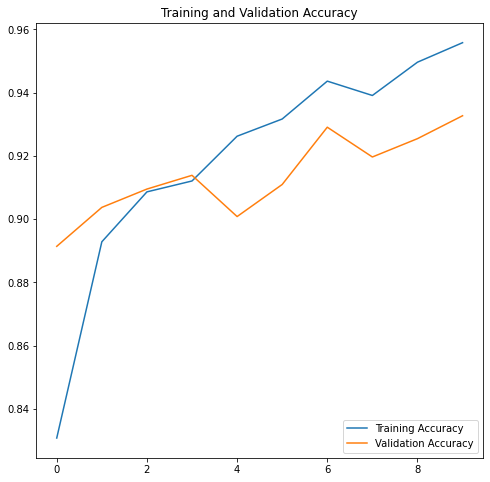

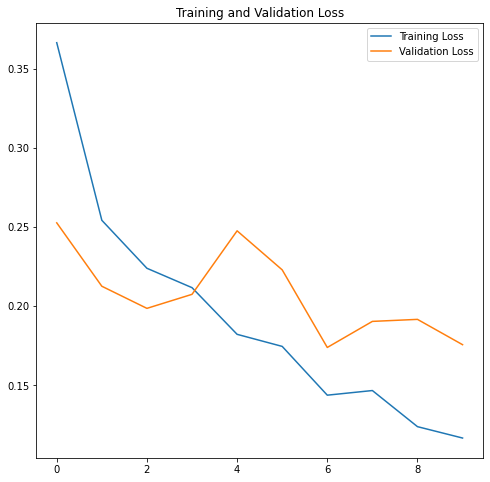

Best val acc:  0.9326574802398682


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('Best val acc: ',max(val_acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[645  47]
 [ 46 643]]


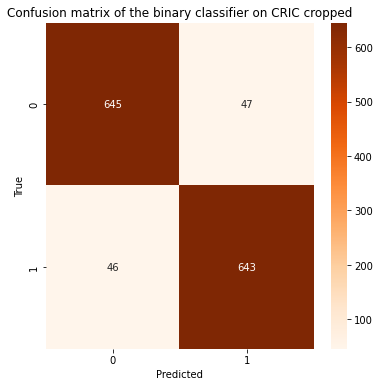

In [63]:
predictions = []
labels = []
for image, label in valid_ds_opt:
  temp_preds = np.round(model.predict(image),0).astype(int)
  predictions.append(temp_preds.flatten())
  temp_labels = label.numpy()
  labels.append(temp_labels.flatten())

predicts_array = np.concatenate(predictions).ravel()
labels_array = np.concatenate(labels).ravel()

# #we construct a confusion matrix
cm1 = cm(labels_array, predicts_array)
print(cm1)

# #we add some colours and labels for easier interpretation
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.title('Confusion matrix of the binary classifier on CRIC cropped')
sns.heatmap(cm1,annot=True,fmt='.3g',cmap='Oranges')
# ax.set_xticklabels(labels,rotation=45)
# ax.set_yticklabels(labels,rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# [[40  0  0  0  0  4]
#  [ 0 48  0  0  0  0]
#  [ 2  0 49  3  0  2]
#  [ 0  0 13 39  0  1]
#  [ 5  6 11 13 13  3]
#  [ 4  0  0  0  0 47]]